In [1]:
import torch
import numpy as np
import zuko
import matplotlib.pyplot as plt
import torch.utils.data as data

from toy_dataset import get_data_sin_rand, get_data_sin

In [2]:
# 2. Get and normalize data
raw_data = get_data_sin_rand(0, 10)
data_mean = raw_data.mean(dim=0)
data_std = raw_data.std(dim=0)
data = (raw_data - data_mean) / data_std

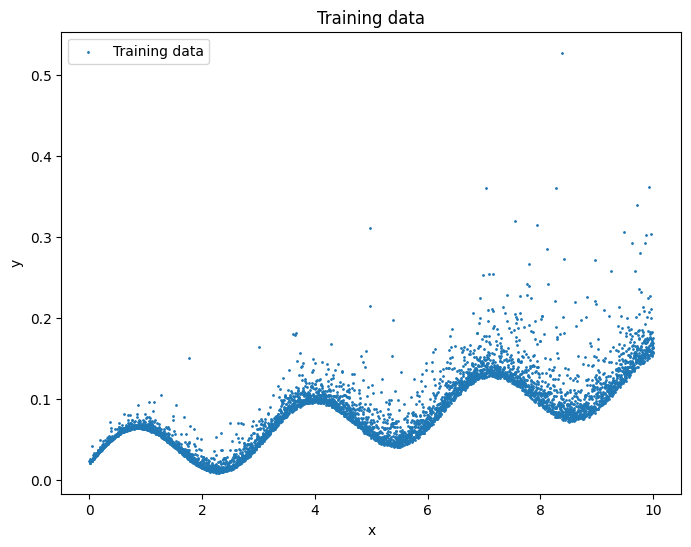

In [3]:
# Plot original data
x = raw_data[:, 0].numpy()
y = raw_data[:, 1].numpy()
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1, label='Training data')
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

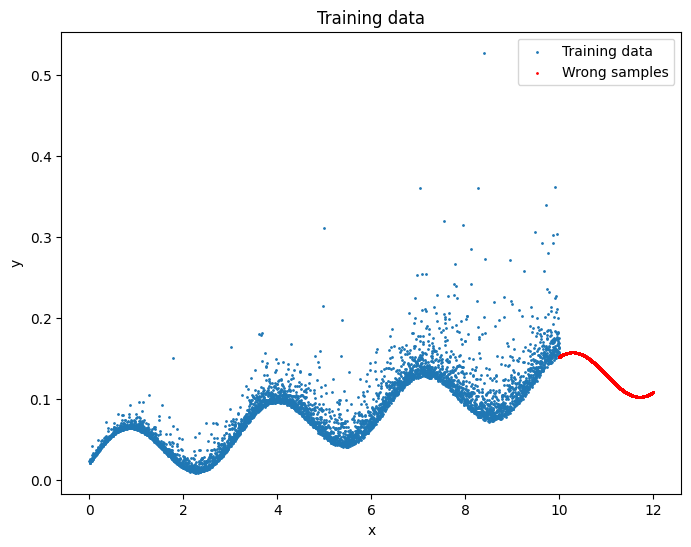

In [4]:
wrong_samples = get_data_sin(10, 12)
x_wrong = wrong_samples[:, 0].numpy()
y_wrong = wrong_samples[:, 1].numpy()
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1, label='Training data')
plt.scatter(x_wrong, y_wrong, s=1, color='red', label='Wrong samples')
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [5]:
# 3. Data loader
batch_size = 64
trainset = torch.utils.data.TensorDataset(data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
# 4. Define conditional flow: p(y | x)
flow = zuko.flows.BPF(features=1, context=1, degree=20, hidden_features=(64, 64))
flow

BPF(
  (transform): LazyComposedTransform(
    (0-2): 3 x ElementWiseTransform(
      (base): BoundedBernsteinTransform()
      (hyper): MLP(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=21, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: tensor([0.]), scale: tensor([1.])))
)

In [7]:
# 5. Training
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
loss_hist = []

for epoch in range(100):
    losses = []

    for (batch,) in trainloader:
        x_ctx = batch[:, 0:1]  # context (x)
        y_val = batch[:, 1:2]  # target (y)

        loss = -flow(x_ctx).log_prob(y_val).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)
    loss_hist.append(losses.mean().item())
    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 1.2453058958053589 ± 0.20560771226882935
(1) 1.0308231115341187 ± 0.1531321406364441
(2) 0.9792282581329346 ± 0.15202857553958893
(3) 0.9649580121040344 ± 0.1476440578699112
(4) 0.9472606182098389 ± 0.16622957587242126
(5) 0.930645227432251 ± 0.17559361457824707
(6) 0.9132441282272339 ± 0.1619100421667099
(7) 0.8917381167411804 ± 0.15614861249923706
(8) 0.8750640153884888 ± 0.12494279444217682
(9) 0.855599582195282 ± 0.1797250360250473
(10) 0.8318333625793457 ± 0.16420875489711761
(11) 0.8100674152374268 ± 0.17150522768497467
(12) 0.787333071231842 ± 0.14968407154083252
(13) 0.7558276653289795 ± 0.16177211701869965
(14) 0.7313680648803711 ± 0.15711919963359833
(15) 0.6952980160713196 ± 0.1405937373638153
(16) 0.6572753190994263 ± 0.1527426540851593
(17) 0.6209985613822937 ± 0.15481318533420563
(18) 0.5755682587623596 ± 0.14262722432613373
(19) 0.5328712463378906 ± 0.1607261747121811
(20) 0.48974522948265076 ± 0.20782573521137238
(21) 0.4512903690338135 ± 0.17142388224601746
(22) 0.

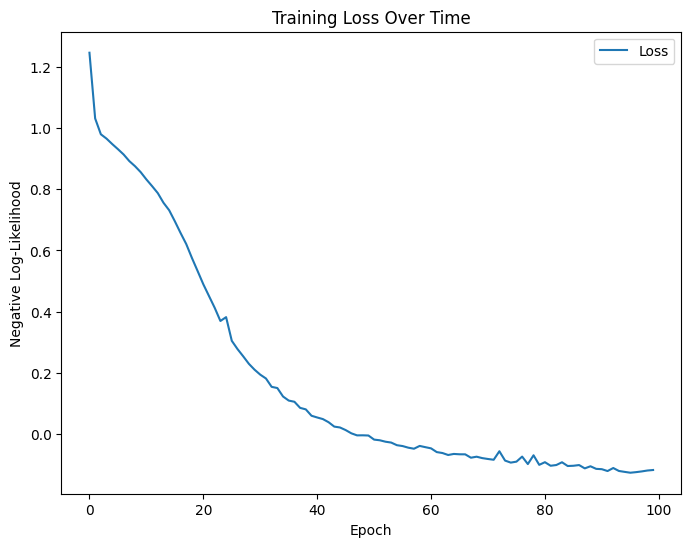

In [8]:
# 6. Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss_hist, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [9]:
# 7. Sample from the learned distribution p(y | x)
x_values = torch.linspace(0, 10, 500).unsqueeze(1)
x_values_norm = (x_values - data_mean[0]) / data_std[0]  # normalize x
samples_norm = flow(x_values_norm).sample((100,))  # (100, 500, 1)
samples = samples_norm * data_std[1] + data_mean[1]  # denormalize y

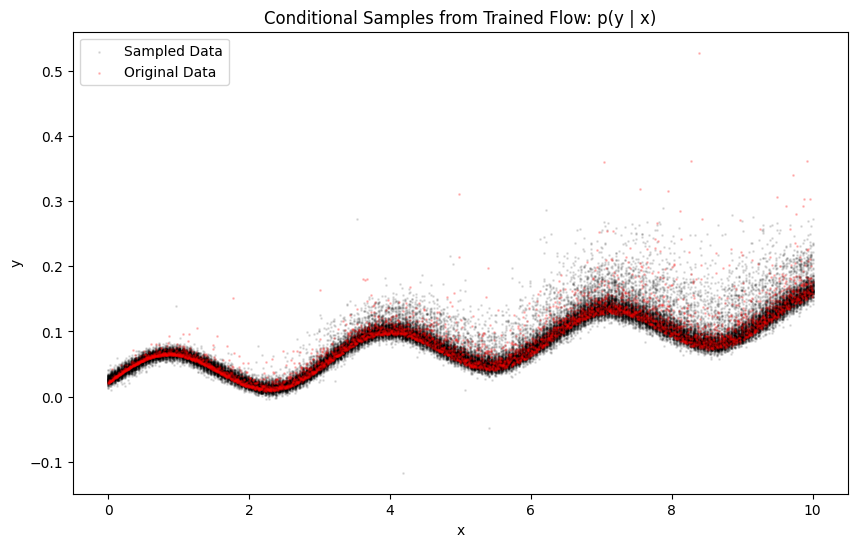

In [10]:
# 8. Plot the sampled y's conditioned on x
plt.figure(figsize=(10, 6))
for i in range(100):  # 100 sampled functions
    plt.scatter(x_values.numpy(), samples[i, :, 0].numpy(), s=1, color='black', alpha=0.1, label="Sampled Data" if i == 0 else "")
plt.scatter(raw_data[:, 0].numpy(), raw_data[:, 1].numpy(), s=1, color='red', alpha=0.2, label="Original Data")
plt.title("Conditional Samples from Trained Flow: p(y | x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


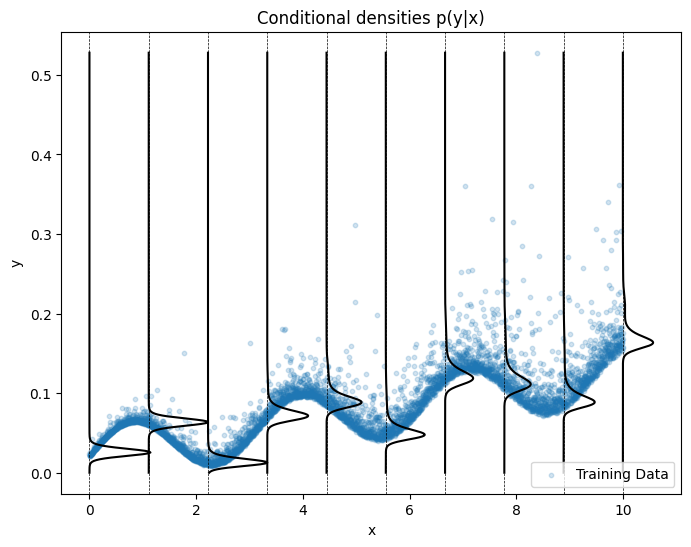

In [15]:
# 9. Plot conditional densities for fixed x values
import seaborn as sns
from scipy.stats import gaussian_kde

y_max = raw_data[:, 1].numpy().max()

x_slices = torch.linspace(0, 10, 10)  # select 10 x values between 0 and 5
ys = torch.linspace(0, y_max, 500)  # y values for evaluating p(y | x)

plt.figure(figsize=(8, 6))

# Normalize x and y
x_slices_norm = (x_slices - data_mean[0]) / data_std[0]
ys_norm = (ys - data_mean[1]) / data_std[1]

for x_val, x_val_norm in zip(x_slices, x_slices_norm):
    x_context = x_val_norm.unsqueeze(0).unsqueeze(0).expand(ys.shape[0], -1)  # shape (500, 1)
    y_eval = ys_norm.unsqueeze(1)  # shape (500, 1)

    with torch.no_grad():
        log_probs = flow(x_context).log_prob(y_eval)
        probs = torch.exp(log_probs).numpy()

    # Scale and shift to x-position for ridge plot
    probs_scaled = probs * 0.3  # scale for display
    plt.plot(probs_scaled + x_val.item(), ys, color='black')

    # Optional: draw vertical reference line
    plt.axvline(x_val.item(), color='black', linestyle='dashed', linewidth=0.5)

plt.scatter(raw_data[:, 0], raw_data[:, 1], alpha=0.2, s=10, label='Training Data')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Conditional densities p(y|x)")
plt.legend()
plt.show()
